In [67]:
import numpy as np                  # Librería para operar matrices y vectores
import matplotlib.pyplot as plt     # Librería para graficar figuras
from keras.datasets import cifar10   # Keras importa la base de datos MNIST
from keras.models import Sequential # Sequential sirve para declarar modelos neuronales
from keras.layers.core import Dense, Dropout, Activation, Flatten # Funciones para declarar capas neuronales específicas 
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils    # np_utils sirve para crear los vectores objetivo
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint


Dimnesiones de X_train = (50000, 32, 32, 3)
Dimensiones de y_train = (50000, 1)


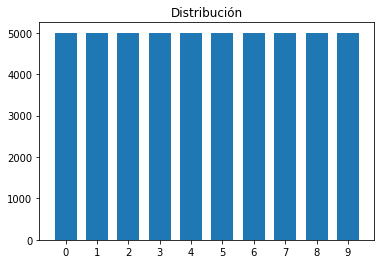

In [2]:
nb_classes = 10
# Base de datos Cifar10: 50,000 ejemplos para entrenamiento y 10,000 ejemplos para verificación
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("Dimnesiones de X_train =", X_train.shape)
print("Dimensiones de y_train =", y_train.shape)
plt.hist(y_train, bins=np.arange(-0.5,10.5,1.0), rwidth=0.7) 
plt.title("Distribución")
plt.xticks(range(10))
plt.show()

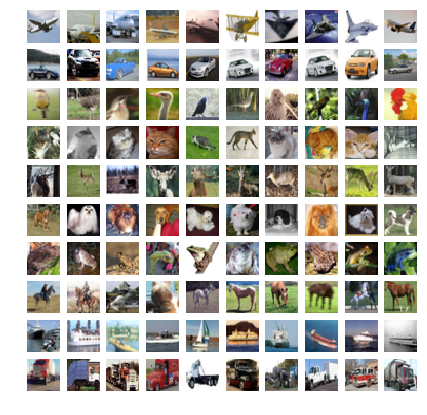

In [3]:
plt.rcParams['figure.figsize'] = (7,7) # Hacer las figuras más grandes

for i in range(10):
    index = np.where(y_train == i)
    index = index[0][np.random.randint(index[0].shape[0], size=10)]
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(X_train[index[j]], cmap='gray', interpolation='none')
        plt.axis('off')
#plt.savefig('cifar10.pdf',bbox_inches='tight',dpi=300)
plt.show()


In [3]:
# Pre-Procesamiento
X_train = X_train.reshape(50000, 32, 32, 3).astype('float32')
X_test = X_test.reshape(10000, 32, 32, 3).astype('float32')
X_train /= 255
X_test /= 255
print("Dimensiones de X_train =", X_train.shape)
print("Dimensiones de y_train =", X_test.shape)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Dimensiones de X_train = (50000, 32, 32, 3)
Dimensiones de y_train = (10000, 32, 32, 3)


In [50]:
# Modelos 
mlp3 = Sequential()
mlp3.add(Flatten(input_shape=X_train.shape[1:]))
mlp3.add(Dense(512, use_bias=True, activation='relu'))                      
mlp3.add(Dense(200, use_bias=True, activation='relu'))
mlp3.add(Dense(100, use_bias=True, activation='relu'))
mlp3.add(Dropout(0.4))
mlp3.add(Dense(nb_classes, use_bias=True, activation='softmax'))

In [60]:
cnn4 = Sequential()  #80%
cnn4.add(Conv2D(32, (3, 3), activation='relu', use_bias=True, padding='same',input_shape=X_train.shape[1:]))
cnn4.add(Conv2D(32, (3, 3), activation='relu', use_bias=True))
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))
cnn4.add(Conv2D(64, (3, 3), activation='relu', use_bias=True, padding='same'))
cnn4.add(Conv2D(64, (3, 3), activation='relu', use_bias=True))
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))
cnn4.add(Flatten())
cnn4.add(Dense(512, activation='relu', use_bias=True))
cnn4.add(Dropout(0.5))
cnn4.add(Dense(nb_classes, use_bias=True, activation='softmax'))

In [68]:
model = Sequential()  #81%
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

In [70]:
# Entrenamiento
model = model
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="bestmodel_cifar10.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='max', period=1)
h = model.fit(X_train, Y_train, batch_size=64, epochs=25, verbose=1, validation_data=(X_test, Y_test), shuffle=True, callbacks=[checkpointer])



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s - loss: 0.5102 - acc: 0.8226 - val_loss: 0.6467 - val_acc: 0.7817

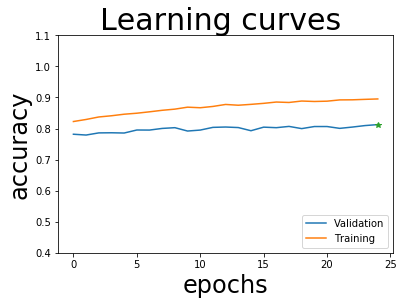

In [71]:
epoch_max = np.argmax(h.history['val_acc'])
plt.plot(h.history['val_acc'], label='Validation')
plt.plot(h.history['acc'], label='Training')
plt.legend(loc='lower right')
plt.plot(epoch_max, h.history['val_acc'][epoch_max],'*')
plt.xlabel('epochs', fontsize=24)
plt.ylabel('accuracy', fontsize=24)
plt.suptitle('Learning curves', fontsize=30)
axes = plt.gca()
axes.set_ylim([0.4,1.1])

#plt.savefig('accuracyVSunits/00ALTaccVSepochs.pdf', bbox_inches='tight')
plt.show()



In [73]:
# Evaluar el mejor modelo
model.load_weights("bestmodel_cifar10.h5")
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.621635162568
Test accuracy: 0.8127


 9600/10000 [===========================>..] - ETA: 0s 

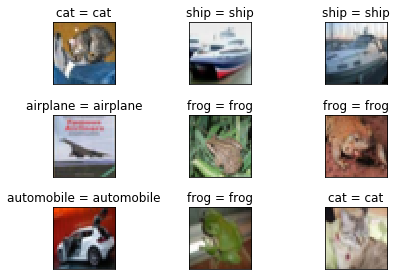

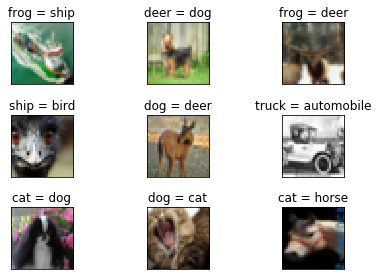

In [72]:
# Inspección visual de los errores
# Modificar este codigo
predicted_classes = model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == np.squeeze(y_test))[0]
incorrect_indices = np.nonzero(predicted_classes != np.squeeze(y_test))[0]

objects = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(32,32,3), interpolation='none')
    plt.title(objects[predicted_classes[correct]] + ' = ' + objects[y_test[correct][0]])
    plt.tick_params(axis='both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off') 
plt.tight_layout()
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(32,32,3), interpolation='none')
    plt.title(objects[predicted_classes[incorrect]] + ' = ' + objects[y_test[incorrect][0]])
    plt.tick_params(axis='both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off') 
plt.tight_layout()
plt.show()
